# Creating a Stress Detection Tool using Data From Mental Health Subreddits: EDA

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk import FreqDist

import pickle

#### Import dataframe from pickle

In [2]:
df = pd.read_pickle('df.pickle')

#### Review dataframe to make sure everything looks right
* .head and .tail
* .shape

In [3]:
df.head(5)

,subreddit,text,text_preproc,scores,compound,score
0,ADHD,"I finally cleaned my entire living space, and ...",i finally cleaned my entire living space and d...,"{'neg': 0.0, 'neu': 0.77, 'pos': 0.23, 'compou...",0.7558,pos
1,ADHD,I found this subreddit,i found this subreddit,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
2,ADHD,Made it through the first week of spring term!...,made it through the first week of spring term ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
3,ADHD,I finally got my Adderall prescription yesterd...,i finally got my adderall prescription yesterd...,"{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...",0.8537,pos
4,ADHD,I finally got my info together to send to my a...,i finally got my info together to send to my a...,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7346,pos


In [4]:
df.tail(5)

,subreddit,text,text_preproc,scores,compound,score
9541,socialanxiety,"true, how ever,, everyone is living in their o...",true how ever everyone is living in their own ...,"{'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'comp...",0.4215,pos
9542,socialanxiety,"You actually don’t know it, you’re just using ...",you actually don’t know it you’re just using l...,"{'neg': 0.138, 'neu': 0.797, 'pos': 0.065, 'co...",-0.4588,neg
9543,socialanxiety,"lol i get this as well. most of the time, they...",lol i get this as well most of the time they a...,"{'neg': 0.054, 'neu': 0.827, 'pos': 0.119, 'co...",0.4019,pos
9544,socialanxiety,For me it's more like I'm scared I'll do somet...,for me its more like im scared ill do somethin...,"{'neg': 0.303, 'neu': 0.574, 'pos': 0.123, 'co...",-0.6213,neg
9545,socialanxiety,Being able to use logic I think is a way of kn...,being able to use logic i think is a way of kn...,"{'neg': 0.062, 'neu': 0.807, 'pos': 0.131, 'co...",0.7096,pos


In [5]:
df.shape

(9546, 6)

#### Count occurences of each subreddit

In [6]:
df['subreddit'].value_counts()

ADHD             3628
Mindfulness      1681
Anxiety          1269
depression       1165
Anger             705
socialanxiety     690
mentalillness     408
Name: subreddit, dtype: int64

#### Subreddits Pie Chart:
* Here we can see the breakdown of which subreddits the comments came from
* Although we called an equal number of 'top posts' from each of these subreddits, each subreddit may have had a different number of top posts and/or number of comments per top post, leading to the discrepencies

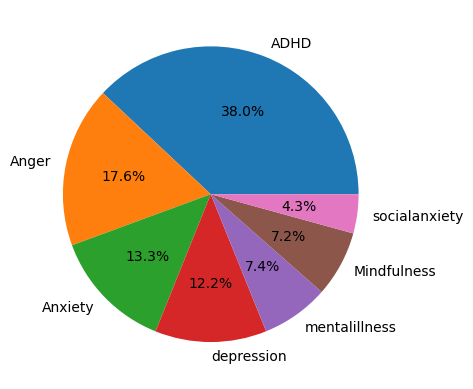

In [7]:
plt.pie(df['subreddit'].value_counts(), labels=df['subreddit'].unique().tolist(), autopct='%1.1f%%')
plt.show()

#### Look at average comment length
* Here we'll look at the min, max, and average length of comments
* Using a histogram we can see that very few comments go above 1500 characters
* The average comment is just under 300 characters

In [8]:
print('Min length: {}'.format(min(df['text_preproc'].str.len())))
print('Max length: {}'.format(max(df['text_preproc'].str.len())))
print('Average Length :  {}'.format(df['text_preproc'].str.len().mean()))

Min length: 0
Max length: 8123
Average Length :  298.45359312801173


<AxesSubplot: >

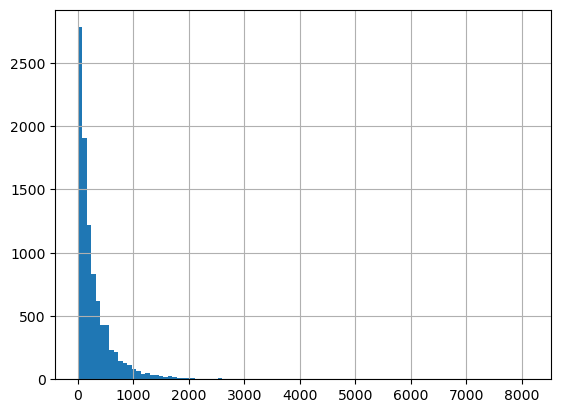

In [9]:
df['text_preproc'].str.len().hist(bins=100)

#### Finding most used words
* First I am making a corpus by iterating through the preprocessed column of the dataframe
* Then using that I can make a word cloud

In [10]:
corpus = {}
corpus_string = ''
for t in df:
    corpus[t]= ' '.join(df['text_preproc'].tolist())
corpus = list(corpus.values())
for x in corpus:
    corpus_string += x

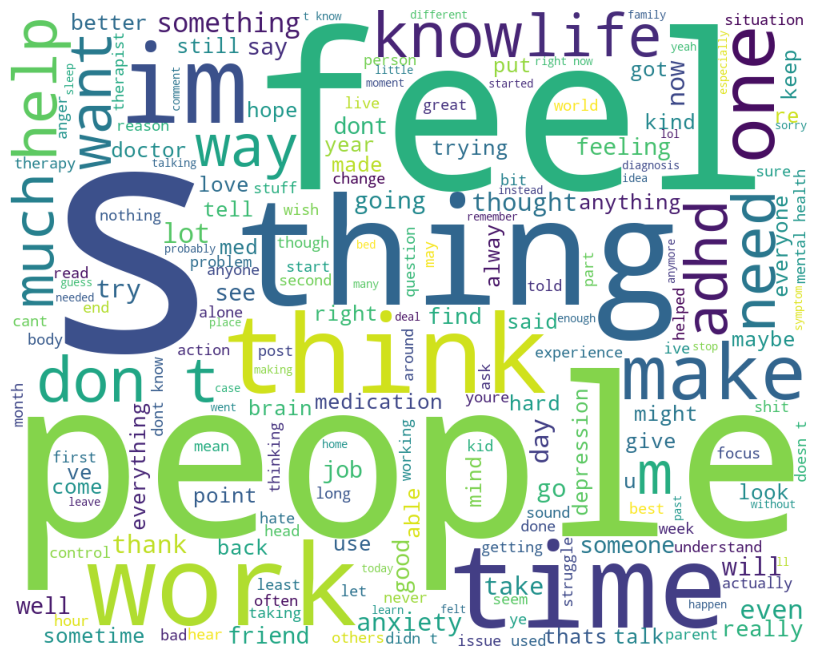

In [11]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white', stopwords = stopwords,
                min_font_size = 10).generate(corpus_string)
plt.figure(figsize = (8, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Most used words:
* Based on the word cloud, certain words stand out, such as 'people,' 'feel,' 'work,' 'help,' and 'think'